# Impact of parity-like (Weinberg) nonlinearity on the local quantum mechanics of harmonic oscillators

## Nonlinear model for a single oscillator

We consider here a single harmonic oscillator with a nonlinerar Hamiltonian function
$$ h(|\psi\rangle,\langle \psi |) = \omega_0 \langle \psi |a^\dagger a |\psi\rangle + \epsilon \frac{\langle \psi |Y |\psi\rangle^2}{\langle \psi |\psi\rangle} $$
where
$$ Y = D^\dagger(\beta) P D(\beta) $$
and $P=e^{i\pi a^\dagger a}$ is the parity operator such that $P|n\rangle=(-1)^n |n\rangle$. We compute the true vacuum $|\tilde{0}\rangle$ of the theory via imaginary time evolution, and displace such numerically obtained vacuum by an amplitude $\alpha_0$ to probe the corrections to $\omega_0$, i.e. to compute the oscillation frequency $\omega$ around $|\tilde{0}\rangle$.

In [2]:
from qutip import *
import numpy as np
import cmath,math
import matplotlib.pyplot as plt
import scipy.special,scipy.signal
from os.path import exists

#----------------------function-definitions-------------------------------------------
#-------------------------------------------------------------------------------------

def progress(t):    
    k=t*100/tmax
    if k%2==0:
        print("Progress: ",str(int(k))+"%",end = "\r")
    return 0

def Htot(Y,psi,eps,w):  # Hamiltonian of the oscillator
    H0 = w*ad*a
    Y0 = expect(Y,psi)/psi.norm()
    Hnl = eps*(2*Y0*Y-Y0*Y0*qeye(N))
    return H0 + Hnl

def evolve_dt(psi0,Y,eps,dt,w):
    h = -1j*Htot(Y,psi0,eps,w)*dt
    U = h.expm()
    return U*psi0
    
def vectopsi(vec):
    states=[]
    for k in range(len(vec)):
        states.append(vec[k]*basis(N,k))
    return sum(states)

def compute_oscillations(psi0,Y,x,eps,w,times):
    #print("Computing dynamics for epsilon=%g..."%(eps))
    dt=times[1]-times[0]
    psi_t=[psi0]
    xs=[expect(x,psi0)]
    for t in times[1:]:
        psi = evolve_dt(psi_t[-1],Y,eps,dt,w)
        psi_t.append(psi)
        xs.append(expect(x,psi))
        progress(t)
    print("--> Completed!")
    return xs

def newFock(n,eps,w,Y):
    state = basis(N,n)
    for k in [i for i in range(N) if i != n]:
        cnk = 2*(eps/w)*Y[n][n]*Y[n][k]/(n-k)
        state += cnk*basis(N,k)        
    return state/state.norm()

def exactground(eps,w,Ynk,dt):
    print("Computing ground state for eps = %g ..."%(eps))
    psi0=newFock(0,eps,w,Ynk)
    psit=[psi0,evolve_dt(psi0,Y,eps,dt,w)]
    counter=0
    while (psit[-1]-psit[-2]).norm()>(10.E-8)*dt:
        counter+=1
        if counter>10.E6: 
            print("counter overflow")
            break
        else:
            psi = psit[-1]
            newpsi = evolve_dt(psi,Y,eps,-1j*dt,w)
            newpsi = newpsi / newpsi.norm()
            psit.append(newpsi)
    print("Done!")
    print("counter = %g , norm = %g"%(counter,(psit[-1]-psit[-2]).norm()))
    return psit[-1]
    
def oscfrequency(psi0,Y,x,eps,w,times):
    dt=times[1]-times[0]
    if eps==0:
        return 1.
    else:
        alpha0 = abs(expect(x,psi0))
        xt = compute_oscillations(psi0,Y,x,eps,w,times)
        curve = [-abs(x) for x in xt]
        zeroes, _ = scipy.signal.find_peaks(curve)
        print("zeroes = ",zeroes)
        zeroes.sort()
        tzeroes = dt*zeroes[0:3]
        T = tzeroes[2]-tzeroes[0]
        return 1. / T
    
def freqsalpha(ground,eps,w,Y,x,times,alphas):
    ws=[]
    for alpha in alphas:
        print("eps = %g , alpha = %g"%(eps,alpha))
        D = (alpha*ad - np.conj(alpha)*a).expm()
        Dground = D*ground
        freq = oscfrequency(Dground,Y,x,eps,w,times)
        print("w = %g"%freq)
        ws.append(freq)
    return ws
        
    

#-----------------------PARAMETERS----------------------------------------------------
#-------------------------------------------------------------------------------------

N = 20 # Fock space cut-off
epsilon = 0.01
w = 2*np.pi
beta = 1j*np.pi/4
a = destroy(N)
ad = a.dag()
x = (a+ad)/2
P = (1j*np.pi*ad*a).expm()
D = (np.conj(beta)*a-beta*ad).expm()
Y = D.dag()*P*D
dt = 0.0001
tmax = 2.
times = np.arange(0,tmax,dt)

Ynk = [ [ (Y*basis(N,k)).overlap(basis(N,n)) for k in range(N) ] for n in range(N) ]
#print([[round(x.real,4)+1j*round(x.imag,4) for x in y] for y in Ynk])

### Numerical evaluation of the true vacuum

Here we compute the true ground state of the system via imaginary time evolution of a state which is close enough to the ground state. This is done by the function exactground(). The particular state from which we start the imaginary time evolution is the ground state obtained via first order perturbation theory. 

We then displace this exact ground state by a small amplitude $\alpha_0$ and observe the associated oscillations. The results are in the form of two lists: osc0 contains the solution in the linear case, while osc1 contains the solution for a finite value of $\epsilon$. We then use the function oscfrequency() to extract the frequency of oscillations via the distance between zeroes.

In this paragraph the oscillating dynamics can be observed for the chosen value of $\epsilon$. In the paragraphs below the actual general computation is carried.

In [ ]:
epsilon = 0.5
dt = 0.001

oldground = basis(N,0)
ground = exactground(epsilon,w,Ynk,dt)
pertground = newFock(0,epsilon,w,Ynk)
#x0 = compute_oscillations(oldground,Y,(a+ad)/2,epsilon,w,times)
#xs = compute_oscillations(ground,Y,(a+ad)/2,epsilon,w,times)
#xs0 = compute_oscillations(pertground,Y,(a+ad)/2,epsilon,w,times)
alpha = 1
Displ = (alpha*ad - np.conj(alpha)*a).expm()
Displground = Displ*ground

osc0 = compute_oscillations(Displground,Y,(a+ad)/2,0,w,times)
osc1 = compute_oscillations(Displground,Y,(a+ad)/2,epsilon,w,times)


fig1=plt.figure()
#plt.plot(times,np.array(x0),lw=2.,label="old ground")
#plt.plot(times,np.array(xs),lw=2.,label="exact ground")
#plt.plot(times,np.array(xs0),lw=2.,label="perturbative ground")
plt.plot(times,np.array(osc0),lw=2.,label="linear")
plt.plot(times,np.array(osc1),lw=2.,label="nonlinear")
plt.xlabel(r'$t$',size=15)
plt.ylabel(r'$x(t)$',size=15)
plt.legend()
plt.margins(0)
#plt.savefig('nl_osc_oscillations_%g.png'%(n_mean),dpi=600)
plt.tight_layout()
plt.show()

### Nonlinear corrections to the frequency of oscillations around the true vacuum

With $\omega=2\pi$, we take the true vacuum of the theory obtained numerically, and we displace it by a small amplitude $\alpha_0$. We then let this state evolve and we analyse the resulting oscillation frequency $\omega$. This is done for a set of values for $\epsilon$ that is called epsvals and can be set freely. The variables alphamin and alphamax set the min/max values for the initial displacement $\alpha_0$ while nalpha is the number of steps in the interval $[\alpha_{min},\alpha_{max}]$. The values for $\epsilon$ are rescaled by $2\pi$ to have the ratio $\epsilon/\omega$ to be an exact power of ten. The resulting frequencies are stored in a file and post-processed in the next paragraph.

In [9]:
dt = 0.0002
nalpha = 40
alphamin = 1.e-3
alphamax = 2.
alphas = np.linspace(alphamin,alphamax,nalpha)
epsvals = [0.,0.001,0.01,0.1]
epsvals = [2*math.pi*x for x in epsvals]

curves=[]

if exists('oscfreq_dt=%g_nalpha=%g_dHilbert=%g.txt'%(dt,nalpha,N)):
    with open('oscfreq_dt=%g_nalpha=%g_dHilbert=%g.txt'%(dt,nalpha,N), "r") as file:
        epsvals0 = []
        for line in file:
            if line.startswith("eps"):
                epsvals0.append(float(line.strip("eps =")))
        file.close()
    epsvals = [x for x in epsvals if x not in epsvals0]
    
else:
    file = open('oscfreq_dt=%g_nalpha=%g_dHilbert=%g.txt'%(dt,nalpha,N), "w")
    file.write("times : \n")
    for t in times:
        file.write(str(t)+" ")
    file.write("\n")
    file.close()

file = open('oscfreq_dt=%g_nalpha=%g_dHilbert=%g.txt'%(dt,nalpha,N), "a")
for eps in epsvals:
    file.write("eps ="+str(eps)+"\n")
    ground = exactground(eps,w,Ynk,dt)
    newcurve = freqsalpha(ground,eps,w,Y,(a+ad)/2,times,alphas)
    print("curve = ",[round(val,6) for val in newcurve])
    curves.append(newcurve)
    for x in newcurve:
        file.write(str(x)+" ")
    file.write("\n")
        
file.close()

Computing ground state for eps = 0.0628319 ...
Done!
counter = 6331 , norm = 1.99921e-11
eps = 0.0628319 , alpha = 0.001
--> Completed!
zeroes =  [ 2488  7463 12439 17414]
w = 1.00492
eps = 0.0628319 , alpha = 0.0522564
--> Completed!
zeroes =  [ 2488  7464 12439 17415]
w = 1.00492
eps = 0.0628319 , alpha = 0.103513
--> Completed!
zeroes =  [ 2489  7465 12441 17417]
w = 1.00482
eps = 0.0628319 , alpha = 0.154769
--> Completed!
zeroes =  [ 2489  7466 12443 17420]
w = 1.00462
eps = 0.0628319 , alpha = 0.206026
--> Completed!
zeroes =  [ 2490  7468 12446 17424]
w = 1.00442
eps = 0.0628319 , alpha = 0.257282
--> Completed!
zeroes =  [ 2490  7470 12449 17428]
w = 1.00412
eps = 0.0628319 , alpha = 0.308538
--> Completed!
zeroes =  [ 2491  7472 12453 17434]
w = 1.00381
eps = 0.0628319 , alpha = 0.359795
--> Completed!
zeroes =  [ 2491  7474 12458 17441]
w = 1.00331
eps = 0.0628319 , alpha = 0.411051
--> Completed!
zeroes =  [ 2492  7477 12463 17448]
w = 1.00291
eps = 0.0628319 , alpha = 0.462

### Post-processing of the curves

Here we read from the file and we construct the final plot with the frequency shifts in terms of $\alpha_0$.

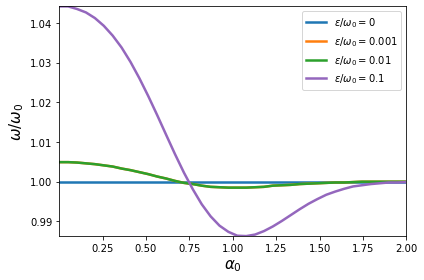

In [11]:
dt = 0.0002
N = 20
nalpha = 40
alphamin = 1.e-3
alphamax = 2.
alphas = np.linspace(alphamin,alphamax,nalpha)
epsvals = []
curves = []


with open('oscfreq_dt=%g_nalpha=%g_dHilbert=%g.txt'%(dt,nalpha,N), "r") as file:
    lines = file.readlines()
    #print(lines)
    lineindices = []
    for k in range(len(lines)):
        if lines[k].startswith("eps"):
            epsvals.append(float(lines[k].strip("eps =")))
            lineindices.append(k+1)
    for k in lineindices:
        line = lines[k].split()
        curve = [float(line[j]) for j in range(len(line)) ]
        #print(curve)
        curves.append([float(x) for x in curve])
file.close()

ordered_data = sorted(zip(epsvals,curves), key=lambda pair: pair[0])
epsvals = [x[0] for x in ordered_data]
curves = [x[1] for x in ordered_data]


fig3 = plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for k in range(len(epsvals)):
    color = colors[k % len(colors)]
    plt.plot(alphas,np.array(curves[k]),lw=2.5,color=color,label=r'$\epsilon/\omega_0=%g$'%(epsvals[k]/(2*math.pi)))
    

plt.xlabel(r'$\alpha_0$',size=15)
plt.ylabel(r'$\omega/\omega_0$',size=15)
plt.legend()
plt.margins(0)
plt.savefig('osc_frequency_dt=%g_nalpha=%g_dHilbert=%g.svg'%(dt,nalpha,N),dpi=600)
plt.tight_layout()
plt.show()